## **Capstone MDS - Preprocesamiento RNN**

#### **_Integrantes:_**  

1. Evans Díaz   
1. Felipe Ojeda
1. Javier Cofre  
1. Luis Reinoso

In [3]:
# importar librerías
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import StandardScaler, OneHotEncoder,\
                                  LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from matplotlib.ticker import EngFormatter

In [4]:
# función para el calculo de outliers
def get_outliers (df, col):
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    iqr = q3 - q1

    upper_limit = q3 + 1.5*iqr
    lower_limit = q1 - 1.5*iqr

    return lower_limit, upper_limit

In [5]:
# función para los gráficos de dispersion
def scatter_plot(df, col, y):
    #definimos el dataframe objetivo
    df_num = df[col]

    # Definir la variable target
    y = y

    # Calcular la cantidad de filas y columnas necesarias para los subgráficos
    num_variables = len(df_num.columns)  # Excluimos la variable target
    num_rows, num_cols = divmod(num_variables, 4)
    if num_cols > 0:
        num_rows += 1

    # Crear el gran gráfico de dispersión con todas las variables numéricas correlacionadas con 'y'
    fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(15, 3*num_rows))
    for i, column in enumerate(df_num.columns.drop(y)):
        sns.scatterplot(data=df_num, x=column, y=y, ax=axes[i // 4, i % 4], alpha=0.5)

    # Ajustar los títulos de los subgráficos
    for i, column in enumerate(df_num.columns.drop(y)):
        axes[i // 4, i % 4].set_title(column)

    plt.tight_layout()
    plt.show()

In [6]:
# funcion para graficar los outliers
def box_plot(df, col):
 
    # definimos el dataframe objetivo
    df_num = df[col]

    # Calcular la cantidad de filas y columnas necesarias para los subgráficos
    num_variables = len(df_num.columns) # Excluimos la variable target
    num_rows, num_cols = divmod(num_variables, 4)
    if num_cols > 0:
        num_rows += 1

    # Crear el gran gráfico de dispersión con todas las variables numéricas correlacionadas con 'y'
    fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(15, 3*num_rows))
    for i, column in enumerate(df_num.columns):
        sns.boxplot(data=df_num, x=column, ax=axes[i // 4, i % 4])

    # Ajustar los títulos de los subgráficos
    for i, column in enumerate(df_num.columns):
        axes[i // 4, i % 4].set_title(column)

    plt.tight_layout()
    plt.show()

## **_1. Lectura (carga) de los Datos_**

In [7]:
# importamos archivo
df = pd.read_csv('../Data/Data.csv', delimiter=';', header=0)

In [8]:
# miramos el dataframe
df.head()

time shift crew  hour equipment equipment_type  \
0  2022-01-01 00:00:00.000     A   E4     0      C-04          Truck   
1  2022-01-01 00:00:00.000     A   E4     0      C-14          Truck   
2  2022-01-01 00:00:00.000     A   E4     0      C-15          Truck   
3  2022-01-01 00:00:00.000     A   E4     0      C820          Truck   
4  2022-01-01 00:00:00.000     A   E4     0      C823          Truck   

  equipment_equipment_type   total  efectivo  d_prog  ...  distance_down  \
0                CAT 789-D  3600.0       0.0     0.0  ...              0   
1                CAT 789-D  3600.0       0.0     0.0  ...              0   
2                CAT 789-D  3600.0       0.0     0.0  ...              0   
3                Kom.930EN  3600.0    3361.0     0.0  ...            400   
4                Kom.930EN  3600.0    3487.0     0.0  ...            335   

   distance_down_level  distance_up  distance_up_level  expected_time  \
0                    0            0                  0              0   
1                    0            0                  0              0   
2                    0            0                  0              0   
3                 2568          400               4552           1259   
4                 2883          135               3553           1003   

   lift_down  lift_down_level  lift_up  lift_up_level  travel_time  
0          0                0        0              0            0  
1          0                0        0              0            0  
2          0                0        0              0            0  
3        -20              -46       20             41         1385  
4        -23              -39       13             45         1403  

[5 rows x 40 columns]

In [9]:
# información general df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254321 entries, 0 to 2254320
Data columns (total 40 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   time                      object 
 1   shift                     object 
 2   crew                      object 
 3   hour                      int64  
 4   equipment                 object 
 5   equipment_type            object 
 6   equipment_equipment_type  object 
 7   total                     float64
 8   efectivo                  float64
 9   d_prog                    float64
 10  d_noprog                  float64
 11  reserva                   float64
 12  mantencion                float64
 13  mecanica                  float64
 14  electrica                 float64
 15  mant_excl                 float64
 16  mec_excl                  float64
 17  elec_excl                 float64
 18  som_excl                  float64
 19  sin_tiempo                float64
 20  demora                  

<Axes: >

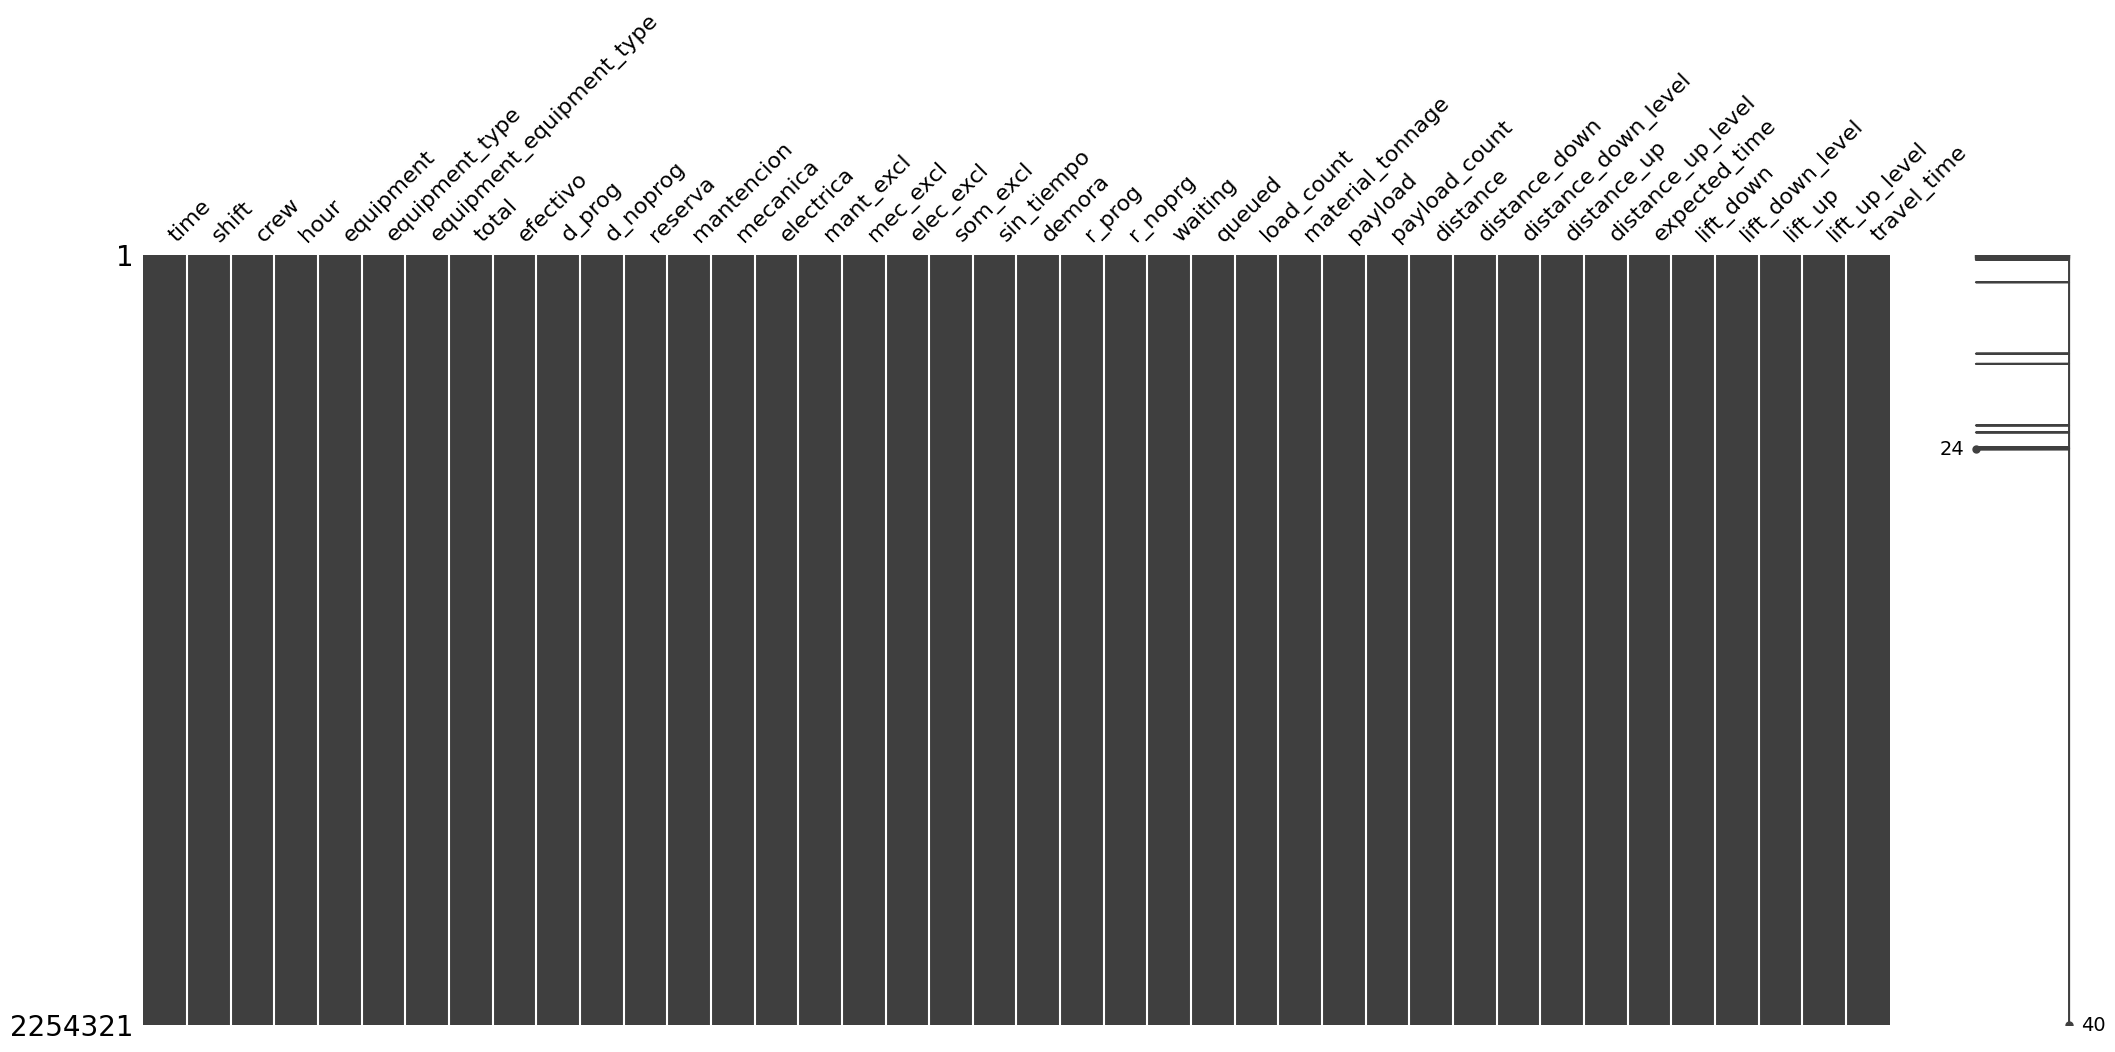

In [10]:
# gráfico de missing values
msno.matrix(df)

In [11]:
# análisis estadístico general del dataframe
df.describe()

hour         total      efectivo     d_prog   d_noprog  \
count  2.254321e+06  2.254169e+06  2.254169e+06  2254169.0  2254169.0   
mean   5.500136e+00  3.599775e+03  2.216603e+03        0.0        0.0   
std    3.452256e+00  2.137174e+01  1.549789e+03        0.0        0.0   
min    0.000000e+00  2.800000e+01  0.000000e+00        0.0        0.0   
25%    3.000000e+00  3.600000e+03  0.000000e+00        0.0        0.0   
50%    6.000000e+00  3.600000e+03  3.118000e+03        0.0        0.0   
75%    9.000000e+00  3.600000e+03  3.600000e+03        0.0        0.0   
max    1.200000e+01  3.600000e+03  3.600000e+03        0.0        0.0   

         reserva    mantencion      mecanica     electrica     mant_excl  ...  \
count  2254169.0  2.254169e+06  2.254169e+06  2.254169e+06  2.254169e+06  ...   
mean         0.0  1.663205e+02  3.883430e+02  1.688208e+01  3.875902e+01  ...   
std          0.0  7.413891e+02  1.088199e+03  2.298555e+02  3.570447e+02  ...   
min          0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
25%          0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
50%          0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
75%          0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
max          0.0  3.600000e+03  3.600000e+03  3.600000e+03  3.600000e+03  ...   

       distance_down  distance_down_level   distance_up  distance_up_level  \
count   2.254321e+06         2.254321e+06  2.254321e+06       2.254321e+06   
mean    2.147614e+03         1.501721e+03  2.237642e+03       3.041467e+03   
std     2.447455e+03         1.622442e+03  2.477436e+03       3.118157e+03   
min     0.000000e+00         0.000000e+00  0.000000e+00       0.000000e+00   
25%     0.000000e+00         0.000000e+00  0.000000e+00       0.000000e+00   
50%     1.300000e+03         1.198000e+03  1.607000e+03       2.632000e+03   
75%     3.994000e+03         2.585000e+03  4.076000e+03       5.179000e+03   
max     2.928700e+04         3.583100e+04  3.014400e+04       4.565000e+04   

       expected_time     lift_down  lift_down_level       lift_up  \
count   2.254321e+06  2.254321e+06     2.254321e+06  2.254321e+06   
mean    1.407410e+03 -2.244376e+02    -3.693516e+01  2.257364e+02   
std     1.275866e+03  2.008712e+03     4.060343e+01  2.657757e+03   
min     0.000000e+00 -2.912906e+06    -7.790000e+02  0.000000e+00   
25%     0.000000e+00 -3.350000e+02    -6.400000e+01  0.000000e+00   
50%     1.518000e+03 -1.080000e+02    -2.800000e+01  1.370000e+02   
75%     2.513000e+03  0.000000e+00     0.000000e+00  3.460000e+02   
max     2.258300e+04  0.000000e+00     0.000000e+00  2.797405e+06   

       lift_up_level   travel_time  
count   2.254321e+06  2.254321e+06  
mean    3.676387e+01  2.062739e+03  
std     3.923774e+01  2.770575e+03  
min    -4.500000e+01 -7.560000e+02  
25%     0.000000e+00  0.000000e+00  
50%     3.000000e+01  2.054000e+03  
75%     6.400000e+01  3.164000e+03  
max     6.200000e+02  4.648480e+05  

[8 rows x 34 columns]

> Tanto la información general del dataframe como el gráfico matrix de "missingno" muestran **_valores faltantes (missing values)_**. Estos corresponden a equipos en arriendo o dados de baja en el periodo de análisis.

## **_2 Preparación del DataFrame_**

### _2.1 Eliminación de Variables_

In [12]:
# quitamos material tonnage
df = df.drop('material_tonnage', axis=1)

In [13]:
# quitamos las flotas no consideradas en el estudio (equipos arriendo o dados de baja)
caex_out = ['CAT 789-C', 'Lieb-T282C1', 'CAT 789-D', 'Lieb-T282B']
df = df[~df['equipment_equipment_type'].isin(caex_out)].reset_index(drop=True)

In [14]:
# quitamos las columnas que no aportan al estudio
df = df.drop(['equipment', 'equipment_type'], axis=1)

In [15]:
# quitamos los missing values (corresponden a ciclos ingresados manualmente)
df= df[~df['total'].isnull()].reset_index(drop=True)

In [16]:
# quitamos datos inconsistentes para el tiempo 'efectivo' 
df= df[~((df['efectivo'] == 0) & (df['payload']>0))].reset_index(drop=True)

# quitamos datos inconsistentes para la variable 'distance' 
df = df[~((df['distance'] == 0) & (df['payload']>0))].reset_index(drop=True)

### _2.2 Missing Values_

> Revisamos la existencia de valores perdidos.

In [17]:
df.isnull().sum()

time                        0
shift                       0
crew                        0
hour                        0
equipment_equipment_type    0
total                       0
efectivo                    0
d_prog                      0
d_noprog                    0
reserva                     0
mantencion                  0
mecanica                    0
electrica                   0
mant_excl                   0
mec_excl                    0
elec_excl                   0
som_excl                    0
sin_tiempo                  0
demora                      0
r_prog                      0
r_noprg                     0
waiting                     0
queued                      0
load_count                  0
payload                     0
payload_count               0
distance                    0
distance_down               0
distance_down_level         0
distance_up                 0
distance_up_level           0
expected_time               0
lift_down                   0
lift_down_

### _2.3 Tratamiento Variable 'time'_

> Agregación de variables a nivel de Turnos.

> Desagregaremos la variable de tiempo en año, mes y dia.

In [18]:
# definimos variable time de tipo datetime
df['time'] = pd.to_datetime(df['time'])


In [19]:
# incorporamos campos para año, mes y dia
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day

In [20]:
# quitamos la variable time
df= df.drop(['time'], axis=1)

In [21]:
# agregamos un contador
df['count'] = 1

### _2.4 Tratamiento Variable 'equipment_equipment_type'_

In [22]:
# agrupamos el dataframe por las variables categóricas y sumamos las variables numéricas
col_cat = ['year', 'month', 'day', 'shift', 'crew', 'equipment_equipment_type']

df_grouped = df.groupby(col_cat).agg('sum').reset_index().copy()
df_grouped

year  month  day shift crew equipment_equipment_type  hour      total  \
0      2022      1    1     A   E4                CAT 797-F   924   604800.0   
1      2022      1    1     A   E4                KOM.960E5   132    86400.0   
2      2022      1    1     A   E4               Kom.930E-4   528   345600.0   
3      2022      1    1     A   E4             Kom.930E-4SE  2172  1422000.0   
4      2022      1    1     A   E4                Kom.930EN   528   345600.0   
...     ...    ...  ...   ...  ...                      ...   ...        ...   
11227  2024      2   29     B   E1               Kom.930E-4   528   345600.0   
11228  2024      2   29     B   E1             Kom.930E-4SE  2244  1468800.0   
11229  2024      2   29     B   E1                Kom.930EN   198   129600.0   
11230  2024      2   29     B   E1                Kom.930ER  1254   820800.0   
11231  2024      2   29     B   E1                Kom.980E5   792   518400.0   

        efectivo  d_prog  ...  distance_down_level  distance_up  \
0       497476.0     0.0  ...               413733       267296   
1        65097.0     0.0  ...                56000        41476   
2       198179.0     0.0  ...               165745       108983   
3      1098300.0     0.0  ...              1242932      1155084   
4       248484.0     0.0  ...               178630       108401   
...          ...     ...  ...                  ...          ...   
11227   264049.0     0.0  ...               302088       141624   
11228  1079695.0     0.0  ...               660914      1402150   
11229    83765.0     0.0  ...                71890        60292   
11230   367279.0     0.0  ...               227667       401861   
11231   427086.0     0.0  ...               282545       522216   

       distance_up_level  expected_time  lift_down  lift_down_level  lift_up  \
0                1134586         326939     -30332           -10739    31404   
1                 136483          40343      -3609            -1460     3509   
2                 394661         119590      -9248            -3638     9179   
3                2240026         826875     -92985           -33813   103183   
4                 454728         133764     -15791            -3949    15528   
...                  ...            ...        ...              ...      ...   
11227             557364         137847      -8533            -6082     9861   
11228            1300787         777756    -158353           -15554   135694   
11229             130719          48342      -8156            -1490     4591   
11230             434892         255960     -47643            -5050    41806   
11231             534606         309507     -57518            -6672    45341   

       lift_up_level  travel_time  count  
0               9345       446142    168  
1               1219        66644     24  
2               3787       228322     96  
3              26346      1039997    395  
4               4183       265958     96  
...              ...          ...    ...  
11227           4738       220245     96  
11228          15729      1207890    408  
11229           1324       105239     36  
11230           5104       411542    228  
11231           7098       401379    144  

[11232 rows x 40 columns]

In [24]:
# quitamos los valores que se agregan y son 0 en las variables numéricas
col_num =[
            'count', 'total', 'hour','efectivo', 'd_prog', 'd_noprog', 'reserva', 'mantencion', 'mecanica', 'electrica', 'mant_excl', 'mec_excl',
            'elec_excl', 'som_excl', 'sin_tiempo', 'demora', 'r_prog', 'r_noprg', 'waiting', 'queued', 'load_count', 'payload', # acá quitamos material_tonnage
            'payload_count', 'distance', 'distance_down', 'distance_down_level', 'distance_up', 'distance_up_level', 'expected_time', 'lift_down',
            'lift_down_level', 'lift_up', 'lift_up_level', 'travel_time'
]      

df_grouped = df_grouped[~(df_grouped[col_num] == 0).all(axis=1)].reset_index(drop=True)

df_grouped

year  month  day shift crew equipment_equipment_type  hour      total  \
0      2022      1    1     A   E4                CAT 797-F   924   604800.0   
1      2022      1    1     A   E4                KOM.960E5   132    86400.0   
2      2022      1    1     A   E4               Kom.930E-4   528   345600.0   
3      2022      1    1     A   E4             Kom.930E-4SE  2172  1422000.0   
4      2022      1    1     A   E4                Kom.930EN   528   345600.0   
...     ...    ...  ...   ...  ...                      ...   ...        ...   
11227  2024      2   29     B   E1               Kom.930E-4   528   345600.0   
11228  2024      2   29     B   E1             Kom.930E-4SE  2244  1468800.0   
11229  2024      2   29     B   E1                Kom.930EN   198   129600.0   
11230  2024      2   29     B   E1                Kom.930ER  1254   820800.0   
11231  2024      2   29     B   E1                Kom.980E5   792   518400.0   

        efectivo  d_prog  ...  distance_down_level  distance_up  \
0       497476.0     0.0  ...               413733       267296   
1        65097.0     0.0  ...                56000        41476   
2       198179.0     0.0  ...               165745       108983   
3      1098300.0     0.0  ...              1242932      1155084   
4       248484.0     0.0  ...               178630       108401   
...          ...     ...  ...                  ...          ...   
11227   264049.0     0.0  ...               302088       141624   
11228  1079695.0     0.0  ...               660914      1402150   
11229    83765.0     0.0  ...                71890        60292   
11230   367279.0     0.0  ...               227667       401861   
11231   427086.0     0.0  ...               282545       522216   

       distance_up_level  expected_time  lift_down  lift_down_level  lift_up  \
0                1134586         326939     -30332           -10739    31404   
1                 136483          40343      -3609            -1460     3509   
2                 394661         119590      -9248            -3638     9179   
3                2240026         826875     -92985           -33813   103183   
4                 454728         133764     -15791            -3949    15528   
...                  ...            ...        ...              ...      ...   
11227             557364         137847      -8533            -6082     9861   
11228            1300787         777756    -158353           -15554   135694   
11229             130719          48342      -8156            -1490     4591   
11230             434892         255960     -47643            -5050    41806   
11231             534606         309507     -57518            -6672    45341   

       lift_up_level  travel_time  count  
0               9345       446142    168  
1               1219        66644     24  
2               3787       228322     96  
3              26346      1039997    395  
4               4183       265958     96  
...              ...          ...    ...  
11227           4738       220245     96  
11228          15729      1207890    408  
11229           1324       105239     36  
11230           5104       411542    228  
11231           7098       401379    144  

[11232 rows x 40 columns]

In [25]:
# pivoteamos el campo 'equipment_equipmemt_type' para que cada uno de sus elementos sea una columna
# y el valor de cada elemento sea el valor de la columna 'count'
df_pivot = df_grouped.pivot_table(index=df_grouped.index, columns='equipment_equipment_type', values='count', aggfunc='sum').reset_index(drop=True)
df_pivot = df_pivot.fillna(0)

# unimos el dataframe en una sola tabla
df_grouped = pd.concat([df_grouped, df_pivot], axis=1)

# quitamos las columnas originales
df_grouped = df_grouped.drop(['equipment_equipment_type', 'count'], axis=1)

# generamos el dataframe final agrupado por turnos
df_grouped_final = df_grouped.groupby(['year', 'month', 'day', 'shift', 'crew']).sum().reset_index()

df_grouped_final


year  month  day shift crew  hour      total   efectivo  d_prog  \
0     2022      1    1     A   E4  6462  4230000.0  2909055.0     0.0   
1     2022      1    1     B   E2  6468  4233600.0  2882182.0     0.0   
2     2022      1    2     A   E4  6457  4226400.0  2749200.0     0.0   
3     2022      1    2     B   E2  6464  4230000.0  2838853.0     0.0   
4     2022      1    3     A   E4  6459  4230000.0  2845762.0     0.0   
...    ...    ...  ...   ...  ...   ...        ...        ...     ...   
1575  2024      2   27     B   E2  6854  4489200.0  3076417.0     0.0   
1576  2024      2   28     A   E3  6725  4402800.0  3030289.0     0.0   
1577  2024      2   28     B   E1  6732  4406400.0  3090974.0     0.0   
1578  2024      2   29     A   E3  6721  4402800.0  3044848.0     0.0   
1579  2024      2   29     B   E1  6732  4406400.0  3057281.0     0.0   

      d_noprog  ...  CAT 798-AC  KOM-CHQ  KOM.960E5  Kom.930E-4  Kom.930E-4SE  \
0          0.0  ...         0.0      0.0       24.0        96.0         395.0   
1          0.0  ...         0.0      0.0       24.0        96.0         396.0   
2          0.0  ...         0.0      0.0       24.0        96.0         394.0   
3          0.0  ...         0.0      0.0       24.0        95.0         396.0   
4          0.0  ...         0.0      0.0       24.0        96.0         395.0   
...        ...  ...         ...      ...        ...         ...           ...   
1575       0.0  ...        24.0      0.0        0.0        96.0         408.0   
1576       0.0  ...        24.0      0.0        0.0        96.0         407.0   
1577       0.0  ...        24.0      0.0        0.0        96.0         408.0   
1578       0.0  ...        24.0      0.0        0.0        96.0         408.0   
1579       0.0  ...        24.0      0.0        0.0        96.0         408.0   

      Kom.930EN  Kom.930ER  Kom.930ER-MT  Kom.980E5  Komatsu AHS  
0          96.0      240.0           0.0      132.0         24.0  
1          96.0      240.0           0.0      132.0         24.0  
2          96.0      240.0           0.0      132.0         24.0  
3          96.0      240.0           0.0      132.0         24.0  
4          96.0      240.0           0.0      132.0         24.0  
...         ...        ...           ...        ...          ...  
1575       48.0      240.0           0.0      144.0          0.0  
1576       36.0      228.0           0.0      144.0          0.0  
1577       36.0      228.0           0.0      144.0          0.0  
1578       36.0      228.0           0.0      144.0          0.0  
1579       36.0      228.0           0.0      144.0          0.0  

[1580 rows x 49 columns]

In [26]:
# eliminamos los 0 adicionales que se crean al agrupar
col_num =   [
            'hour', 'total', 'efectivo', 'd_prog', 'd_noprog', 'reserva', 'mantencion', 'mecanica', 'electrica', 'mant_excl', 'mec_excl', 'elec_excl', 
            'som_excl', 'sin_tiempo', 'demora', 'r_prog', 'r_noprg', 'waiting', 'queued', 'load_count', 'payload', 'payload_count', # acá quitamos material_tonnage
            'distance', 'distance_down', 'distance_down_level', 'distance_up', 'distance_up_level', 'expected_time', 'lift_down', 'lift_down_level',
            'lift_up', 'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM.960E5', 'Kom.930E-4', 'Kom.930E-4SE', 'Kom.930EN', 'Kom.930ER', 'Kom.980E5', 
            'Komatsu AHS', 'KOM-CHQ'
]

df_grouped_final = df_grouped_final[~(df_grouped_final[col_num] == 0).all(axis=1)].reset_index(drop=True)

df_grouped_final.head().style.format({col: "{:.2f}" for col in col_num}).set_properties(**{'background-color': 'lightgray', 'color': 'black'})


In [27]:
# creamos variable de tiempo provisoria
df_grouped_final['time'] = pd.to_datetime(df_grouped_final[['year', 'month', 'day']])

#### _2.5 Análisis Exploratorio (EDA)_

##### _2.5.1 Variable Dependiente_

In [28]:
# descripción estadística de la variable objetivo   
df_grouped_final['payload'].describe().round(2)

count      1580.00
mean     142057.00
std       21352.36
min           0.00
25%      127941.26
50%      140726.92
75%      155701.49
max      203367.36
Name: payload, dtype: float64

> Miramos la forma en que distribuye la variable dependiente y la presencia de Outliers. 

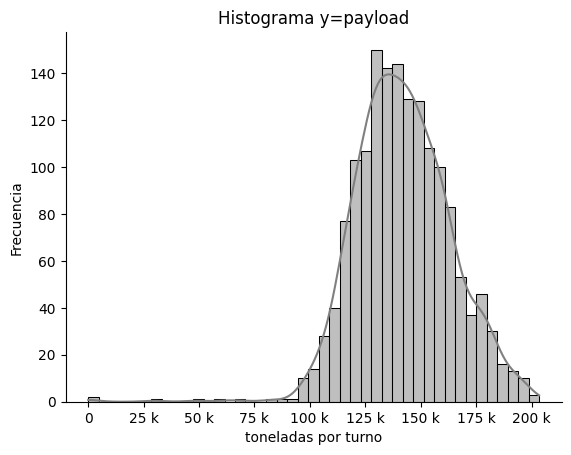

In [29]:
# distribución de la variable dependiente
sns.histplot(x='payload', data=df_grouped_final, kde=True, color='gray')

# elemstos del gráfico
sns.despine()
plt.title('Histograma y=payload')
plt.xlabel('toneladas por turno')
plt.ylabel('Frecuencia')
plt.gca().xaxis.set_major_formatter(EngFormatter())
plt.show()

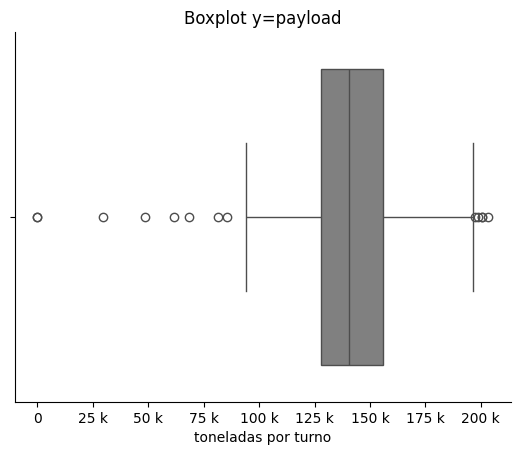

In [30]:
# distribución de la variable dependiente
sns.boxplot(x='payload', data=df_grouped_final, color='gray')

# elemstos del gráfico
sns.despine()
plt.title('Boxplot y=payload')
plt.xlabel('toneladas por turno')
plt.gca().xaxis.set_major_formatter(EngFormatter())
plt.show()

##### _2.5.2 Eliminamos Outliers Variable Objetivo_ 

In [31]:
# definimos los outliers de la variable dependiente
lower_limit, upper_limit = get_outliers(df_grouped_final, 'payload')

# quitar los outliers
df_grouped_final = df_grouped_final[(df_grouped_final['payload'] >= lower_limit) & (df_grouped_final['payload'] <= upper_limit)].reset_index(drop=True)

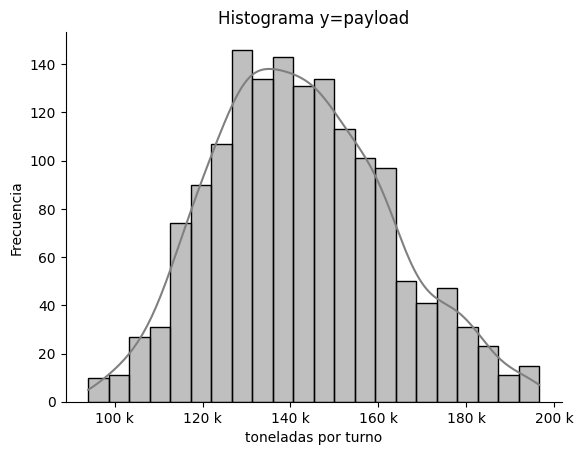

In [32]:
# distribución de la variable dependiente
sns.histplot(x='payload', data=df_grouped_final, kde=True, color='gray')

# elemstos del gráfico
sns.despine()
plt.title('Histograma y=payload')
plt.xlabel('toneladas por turno')
plt.ylabel('Frecuencia')
plt.gca().xaxis.set_major_formatter(EngFormatter())
plt.show()

In [33]:
df_grouped_final['payload'].describe().round(2)

count      1567.00
mean     142357.46
std       19936.06
min       93935.86
25%      127995.41
50%      140838.40
75%      155650.55
max      196636.13
Name: payload, dtype: float64

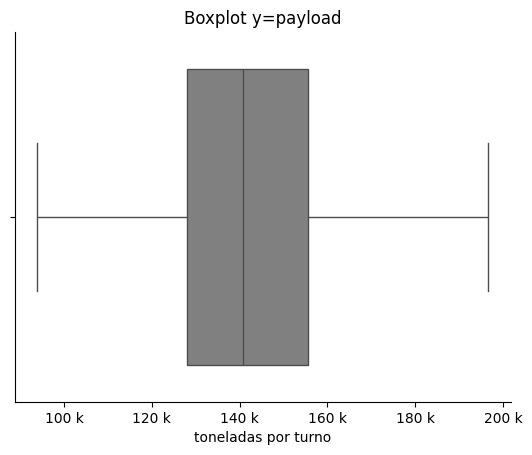

In [34]:
# distribución de la variable dependiente
sns.boxplot(x='payload', data=df_grouped_final, color='gray')

# elemstos del gráfico
sns.despine()
plt.title('Boxplot y=payload')
plt.xlabel('toneladas por turno')
plt.gca().xaxis.set_major_formatter(EngFormatter())
plt.show()

##### _2.5.2 Relación Variable Numéricas vs Variable Objetivo_ 

In [35]:
# columnas numéricas con numpy
col_num = df_grouped_final.select_dtypes(include=[np.number]).columns
col_num 

Index(['year', 'month', 'day', 'hour', 'total', 'efectivo', 'd_prog',
       'd_noprog', 'reserva', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'elec_excl', 'som_excl', 'sin_tiempo',
       'demora', 'r_prog', 'r_noprg', 'waiting', 'queued', 'load_count',
       'payload', 'payload_count', 'distance', 'distance_down',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ',
       'KOM.960E5', 'Kom.930E-4', 'Kom.930E-4SE', 'Kom.930EN', 'Kom.930ER',
       'Kom.930ER-MT', 'Kom.980E5', 'Komatsu AHS'],
      dtype='object')

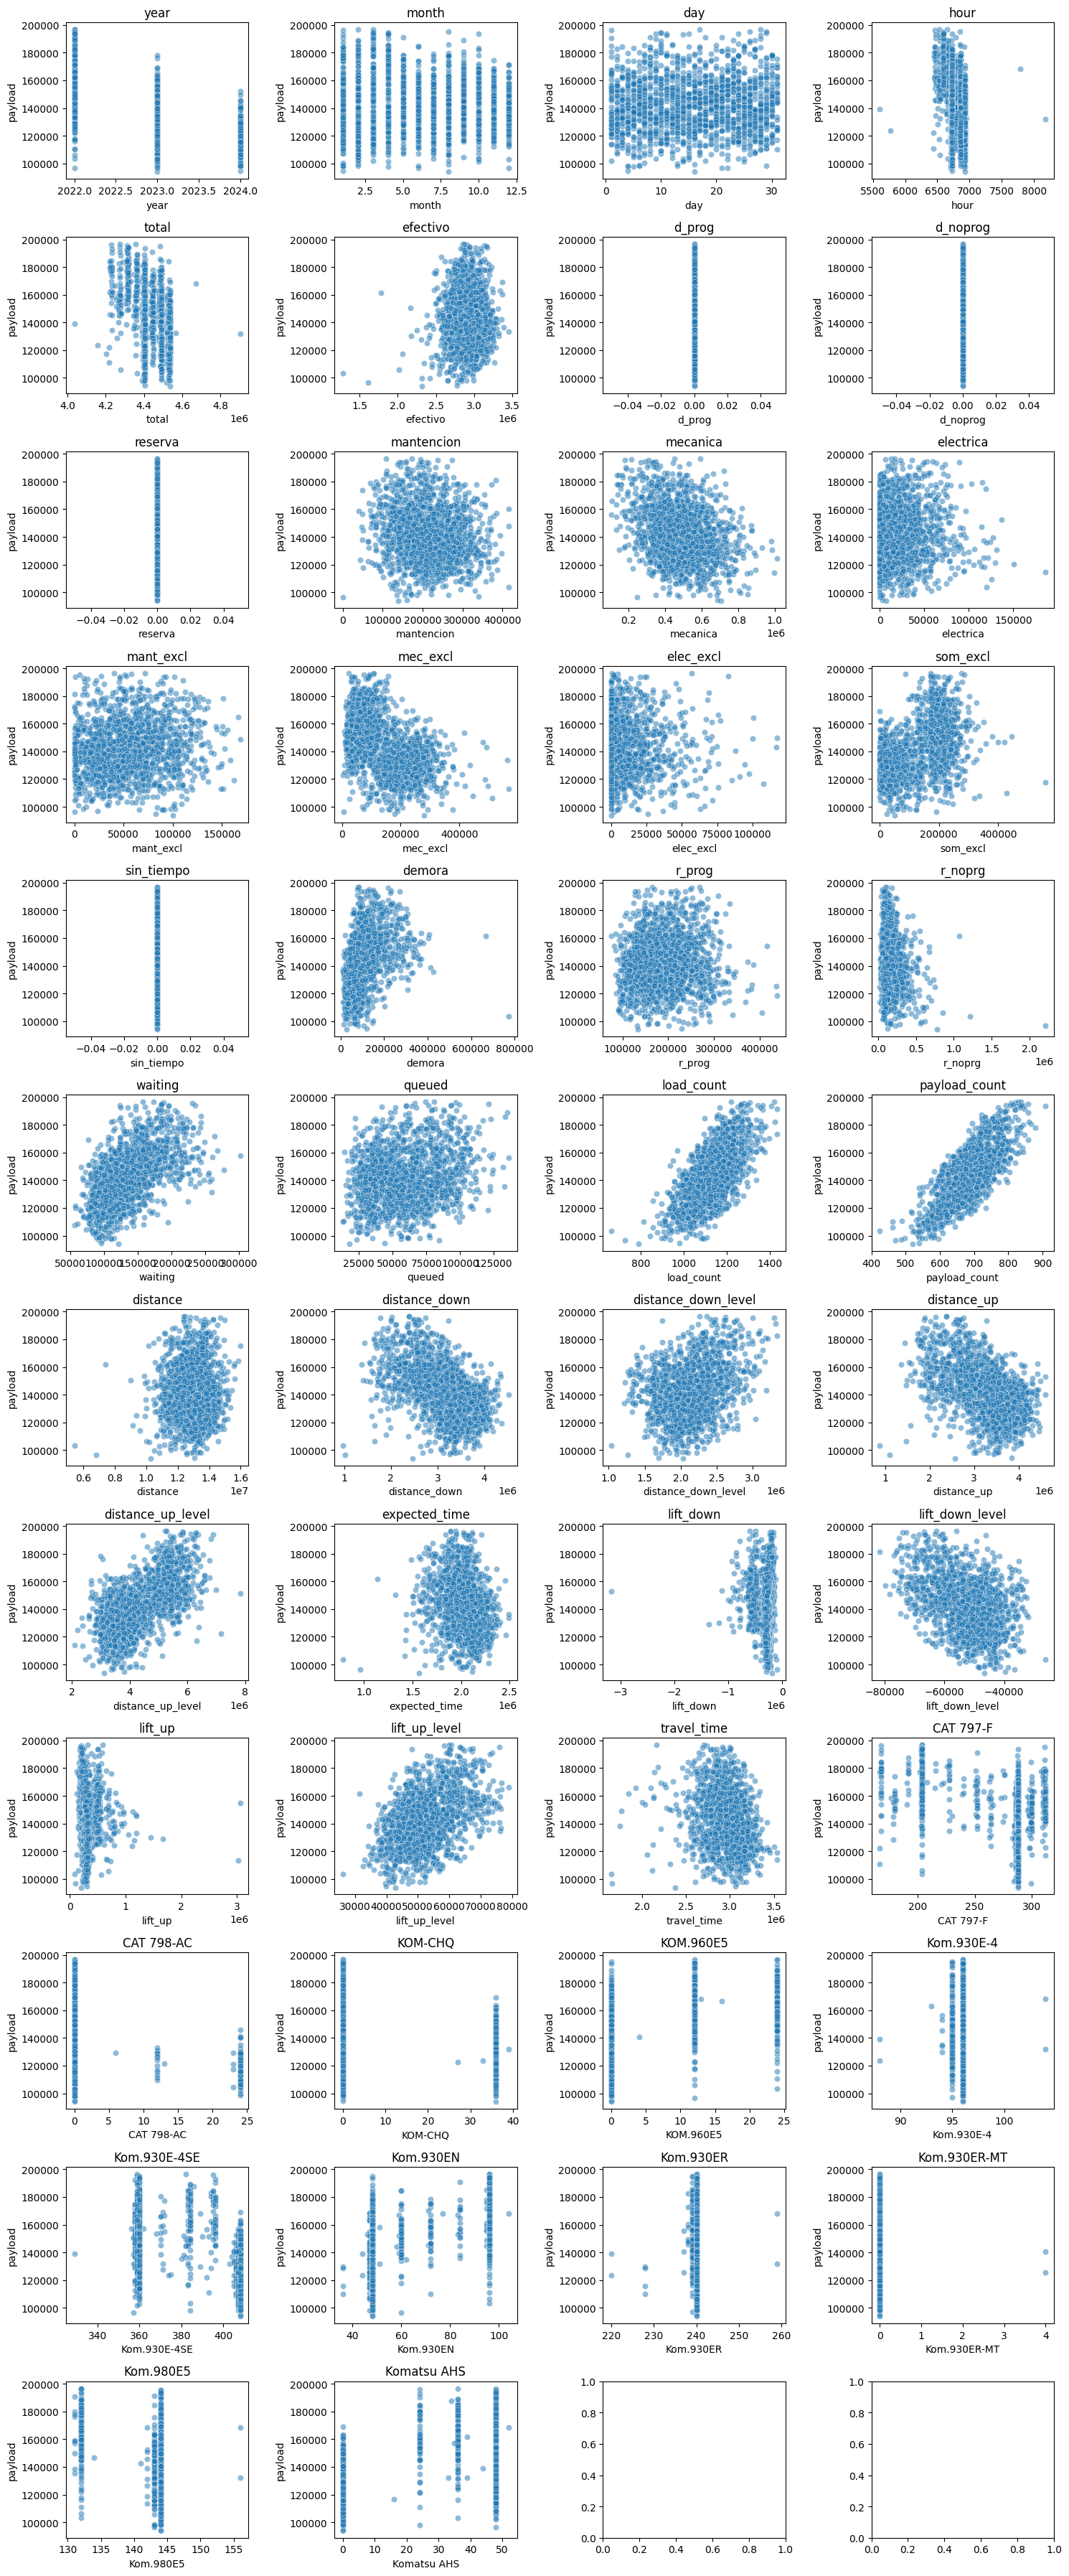

In [36]:
# miramos las relaciones entre la variable objetivo y las dependientes

scatter_plot(df_grouped_final, col_num, 'payload')

> Se puede observar que no todas las variables independientes tienen una relación lineal con la target.
> Existe una serie de variables que poseen valor 0, ya que son parte del sistema de ASARCO antiguo. Dichas variables las quitaremos en el pre procesamiento.

(0.0, 200000.0)

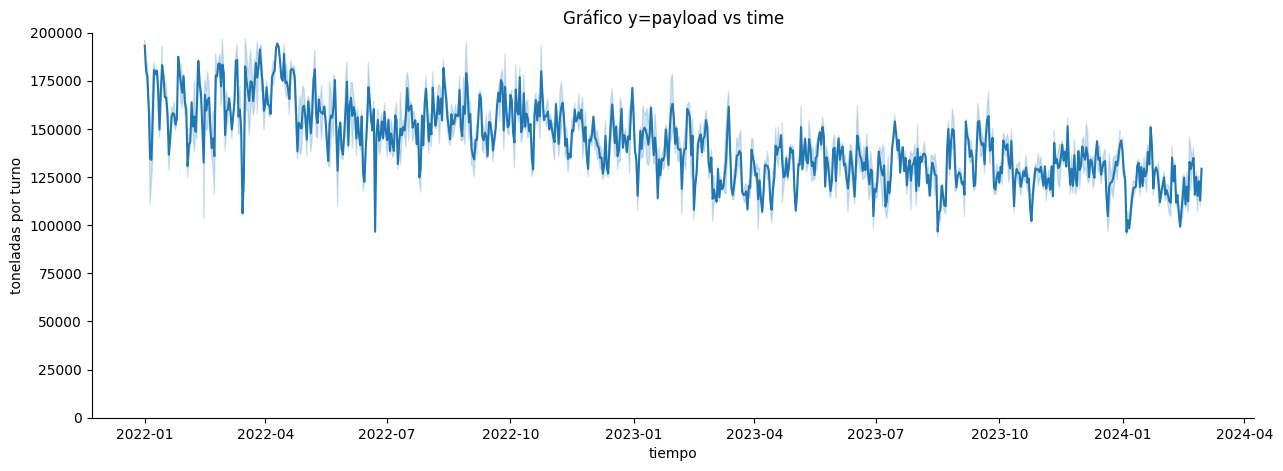

In [37]:
# graficar la variable 'payload' vs time
plt.figure(figsize=(15,5))
sns.lineplot(data=df_grouped_final, x='time', y='payload')

plt.title('Gráfico y=payload vs time')
plt.xlabel('tiempo')
plt.ylabel('toneladas por turno')
sns.despine()
plt.ylim(0, 200000)

(100000.0, 200000.0)

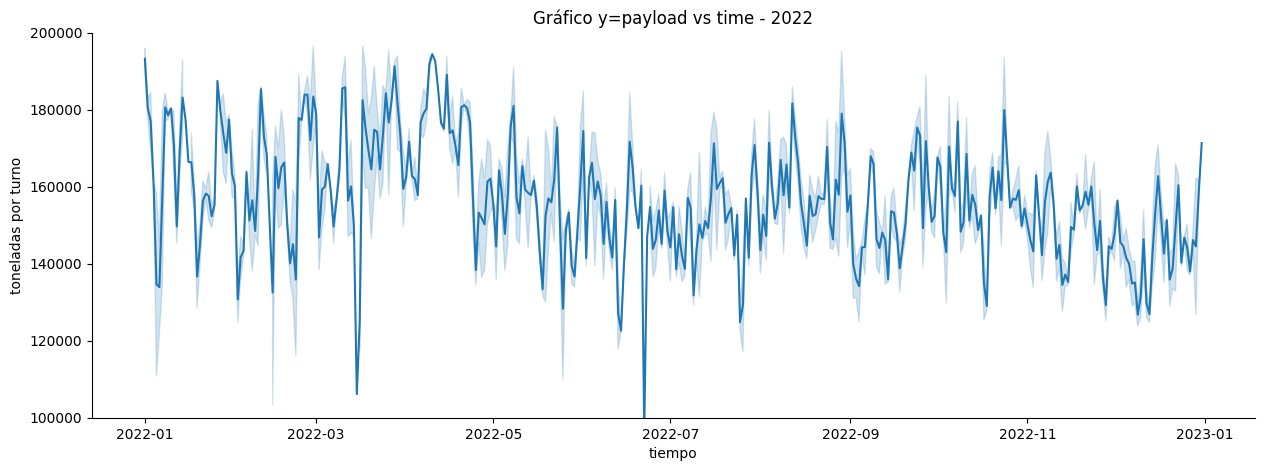

In [38]:
# graficar la variable 'payload' vs time 2022
df_grouped_final_2022 = df_grouped_final[(df_grouped_final['year']==2022)].reset_index(drop=True)
plt.figure(figsize=(15,5))
sns.lineplot(data=df_grouped_final_2022, x='time', y='payload')

plt.title('Gráfico y=payload vs time - 2022')
plt.xlabel('tiempo')
plt.ylabel('toneladas por turno')
sns.despine()
plt.ylim(100000, 200000)

(100000.0, 200000.0)

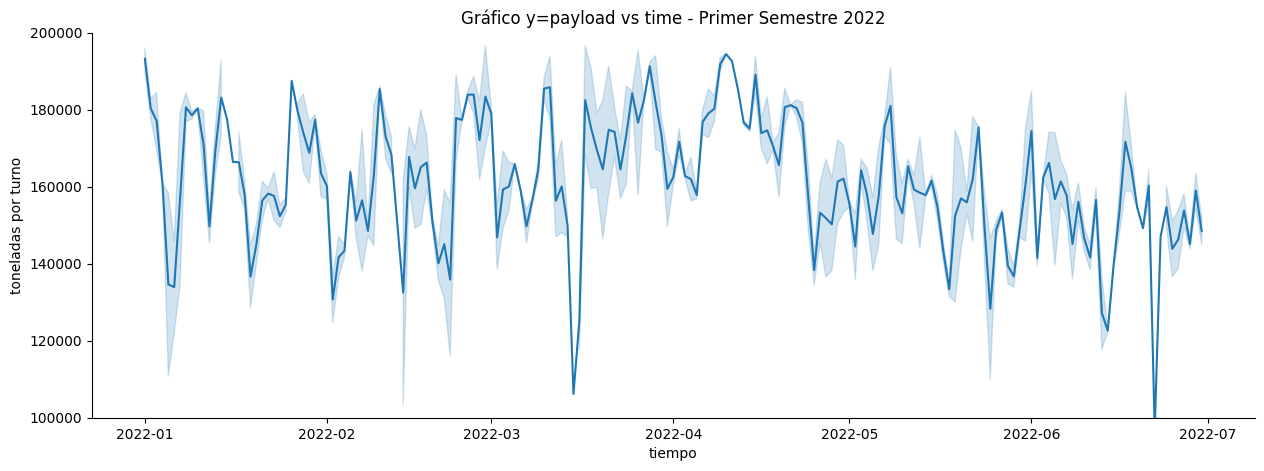

In [39]:
# graficar la variable 'payload' vs time primer semestre 2022
df_grouped_final_2022_1 = df_grouped_final[(df_grouped_final['year']==2022) & (df_grouped_final['month']<=6)].reset_index(drop=True)
plt.figure(figsize=(15,5))
sns.lineplot(data=df_grouped_final_2022_1, x='time', y='payload')

plt.title('Gráfico y=payload vs time - Primer Semestre 2022')
plt.xlabel('tiempo')
plt.ylabel('toneladas por turno')
sns.despine()
plt.ylim(100000, 200000)

(100000.0, 200000.0)

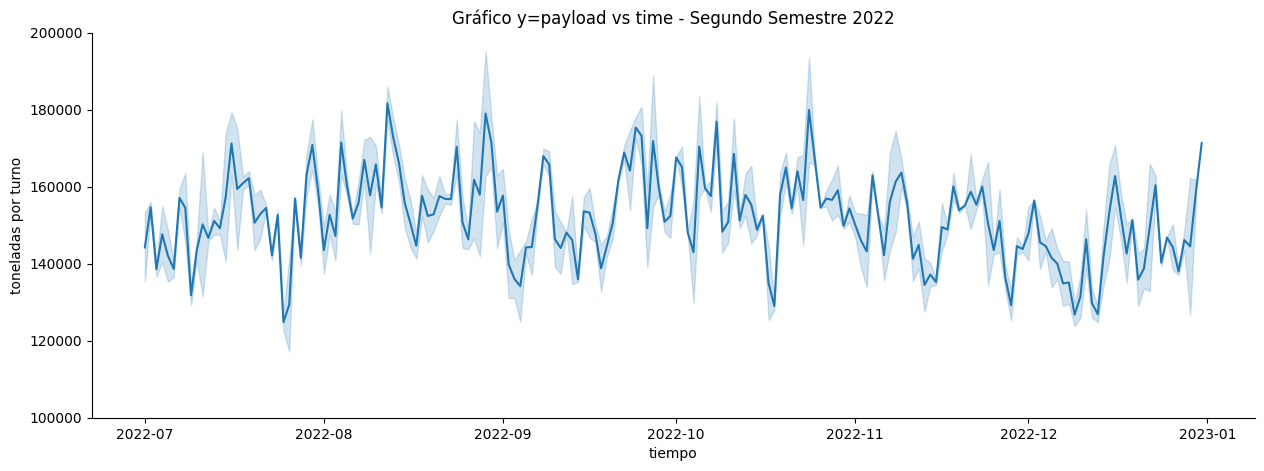

In [40]:
# graficar la variable 'payload' vs time segundo semestre 2022
df_grouped_final_2022_2 = df_grouped_final[(df_grouped_final['year']==2022) & (df_grouped_final['month']>=7)].reset_index(drop=True)
plt.figure(figsize=(15,5))
sns.lineplot(data=df_grouped_final_2022_2, x='time', y='payload')

plt.title('Gráfico y=payload vs time - Segundo Semestre 2022')
plt.xlabel('tiempo')
plt.ylabel('toneladas por turno')
sns.despine()
plt.ylim(100000, 200000)

(100000.0, 200000.0)

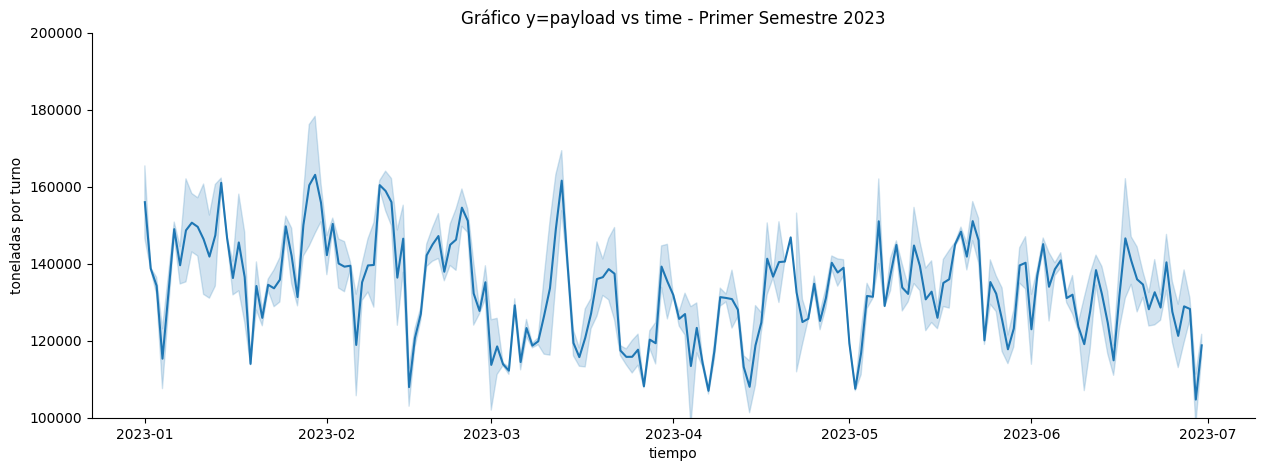

In [41]:
# graficar la variable 'payload' vs time primer semestre 2023
df_grouped_final_2022_2 = df_grouped_final[(df_grouped_final['year']==2023) & (df_grouped_final['month']<=6)].reset_index(drop=True)
plt.figure(figsize=(15,5))
sns.lineplot(data=df_grouped_final_2022_2, x='time', y='payload')

plt.title('Gráfico y=payload vs time - Primer Semestre 2023')
plt.xlabel('tiempo')
plt.ylabel('toneladas por turno')
sns.despine()
plt.ylim(100000, 200000)

(130000.0, 160000.0)

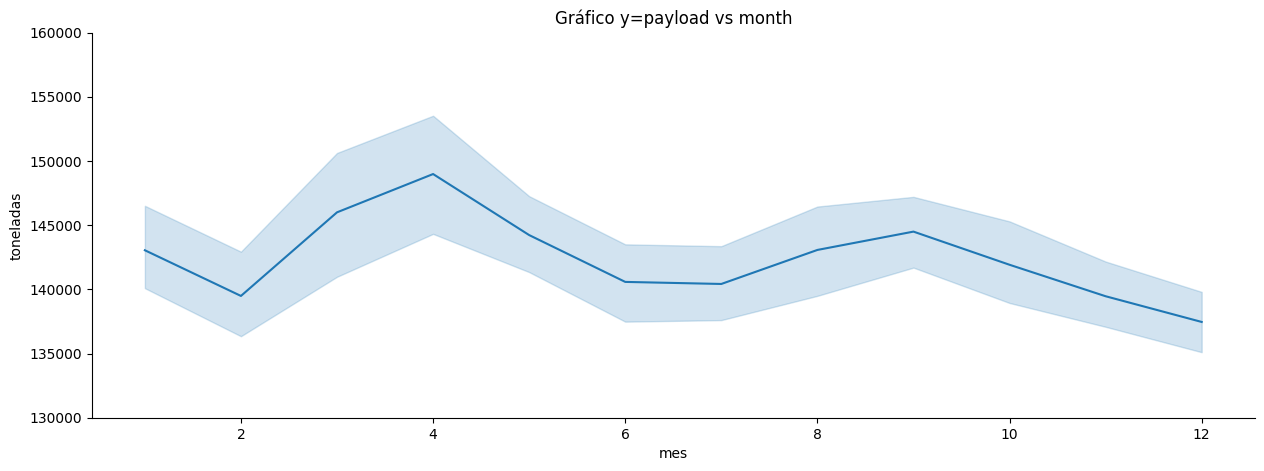

In [42]:
# graficar la variable 'payload' vs 'month'
plt.figure(figsize=(15,5))
sns.lineplot(data=df_grouped_final, x='month', y='payload')

plt.title('Gráfico y=payload vs month')
plt.xlabel('mes')
plt.ylabel('toneladas')
sns.despine()
plt.ylim(130000, 160000)

(130000.0, 160000.0)

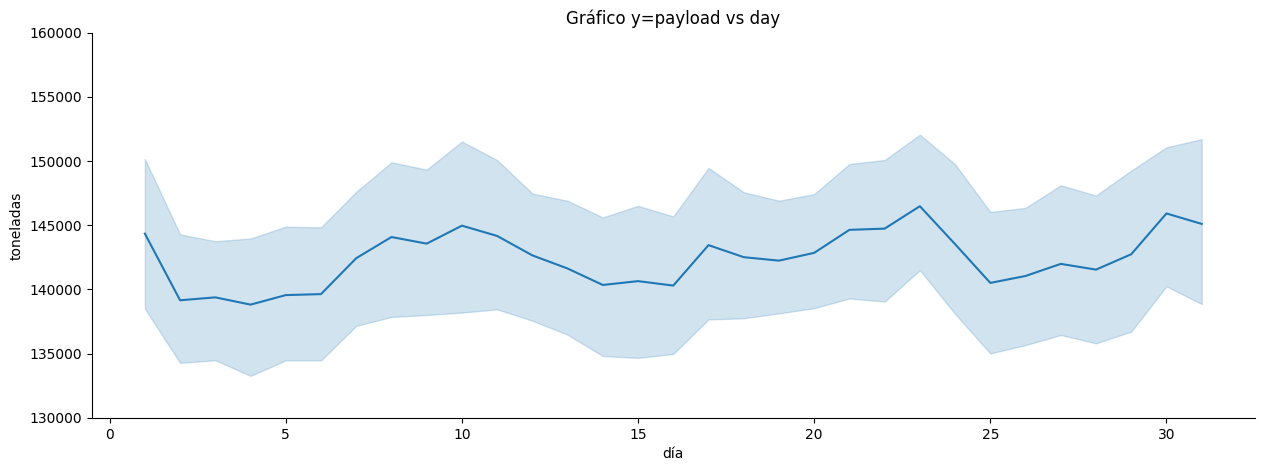

In [43]:
# graficar la variable 'payload' vs 'day'
plt.figure(figsize=(15,5))
sns.lineplot(data=df_grouped_final, x='day', y='payload')

plt.title('Gráfico y=payload vs day')
plt.xlabel('día')
plt.ylabel('toneladas')
sns.despine()
plt.ylim(130000, 160000)

## **_3 Preprocesamiento_**

#### _3.1 Eliminación de Variables_

In [44]:
# quitamos las variables de tiempo 0
var_out = ['d_prog','d_noprog','reserva','sin_tiempo']

df_final = df_grouped_final.drop(var_out, axis=1).copy()

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   year                 1567 non-null   int32         
 1   month                1567 non-null   int32         
 2   day                  1567 non-null   int32         
 3   shift                1567 non-null   object        
 4   crew                 1567 non-null   object        
 5   hour                 1567 non-null   int64         
 6   total                1567 non-null   float64       
 7   efectivo             1567 non-null   float64       
 8   mantencion           1567 non-null   float64       
 9   mecanica             1567 non-null   float64       
 10  electrica            1567 non-null   float64       
 11  mant_excl            1567 non-null   float64       
 12  mec_excl             1567 non-null   float64       
 13  elec_excl            1567 non-nul

#### _3.2 Asignación Tipo de Variable_

In [45]:
# asignamos tipo category a las variables categóricas
df_final['shift'] = df_final['shift'].astype('category')
df_final['crew'] = df_final['crew'].astype('category')
df_final['year'] = df_final['year'].astype('category')
df_final['month'] = df_final['month'].astype('category')
df_final['day'] = df_final['day'].astype('category')

In [46]:
# reordenamos las columnas del dataframe dejando las variables categóricas al principio y las numéricas al final
col_num = df_final.select_dtypes(include=['float64','int64']).columns.tolist()

df_final = df_final[['year', 'month', 'day', 'shift', 'crew']+col_num]
df_final.head()

year month day shift crew  hour      total   efectivo  mantencion  \
0  2022     1   1     A   E4  6462  4230000.0  2909055.0    195378.0   
1  2022     1   1     B   E2  6468  4233600.0  2882182.0    233080.0   
2  2022     1   2     A   E4  6457  4226400.0  2749200.0    276555.0   
3  2022     1   2     B   E2  6464  4230000.0  2838853.0    255450.0   
4  2022     1   3     A   E4  6459  4230000.0  2845762.0    255412.0   

   mecanica  ...  CAT 798-AC  KOM-CHQ  KOM.960E5  Kom.930E-4  Kom.930E-4SE  \
0  215300.0  ...         0.0      0.0       24.0        96.0         395.0   
1  185576.0  ...         0.0      0.0       24.0        96.0         396.0   
2  168400.0  ...         0.0      0.0       24.0        96.0         394.0   
3  161031.0  ...         0.0      0.0       24.0        95.0         396.0   
4  138690.0  ...         0.0      0.0       24.0        96.0         395.0   

   Kom.930EN  Kom.930ER  Kom.930ER-MT  Kom.980E5  Komatsu AHS  
0       96.0      240.0           0.0      132.0         24.0  
1       96.0      240.0           0.0      132.0         24.0  
2       96.0      240.0           0.0      132.0         24.0  
3       96.0      240.0           0.0      132.0         24.0  
4       96.0      240.0           0.0      132.0         24.0  

[5 rows x 45 columns]

#### _3.3 Colinealidad de las variables_

> Miramos normalidad de los datos y colinealidad.

In [47]:
# generamos dataframe con las variables numéricas
df_num = df_final.select_dtypes(include=['float64','int64']).copy()

# definimos la matriz de correlación
corr_matrix = df_num.corr(method='spearman')

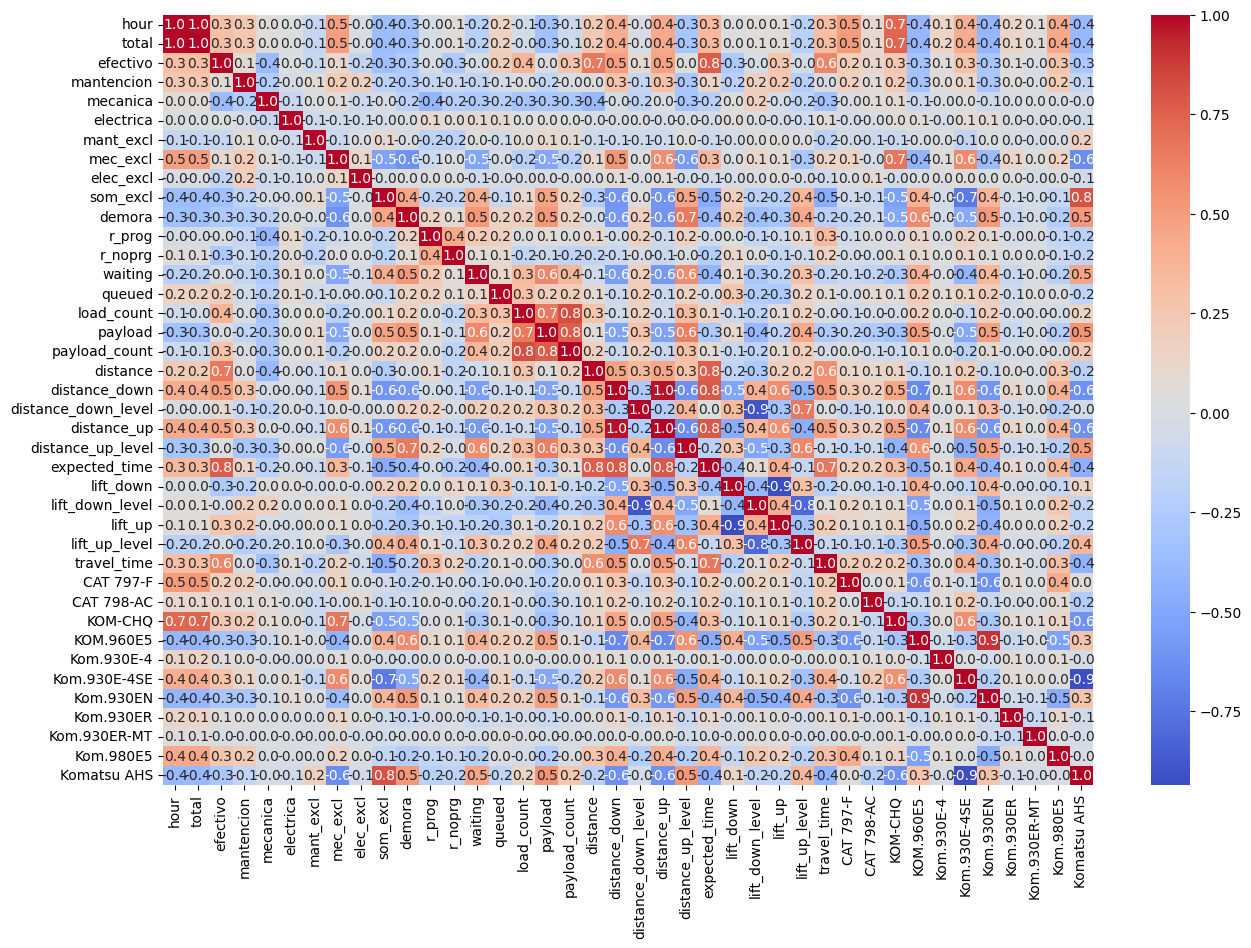

In [48]:
# generamos un heatmap para ver la correlación entre las variables numéricas
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f')

plt.show()

> 1. Quitamos la variable 'load_count' y 'payload_count' que tienen una alta correlación con 'material_tonnage' (target).

In [49]:
# quitamos las variables que tienen una correlación mayor a 0.7 y 'load_count'
var_corr = ['hour','load_count', 'payload_count']
df_num = df_num.drop(var_corr, axis=1)

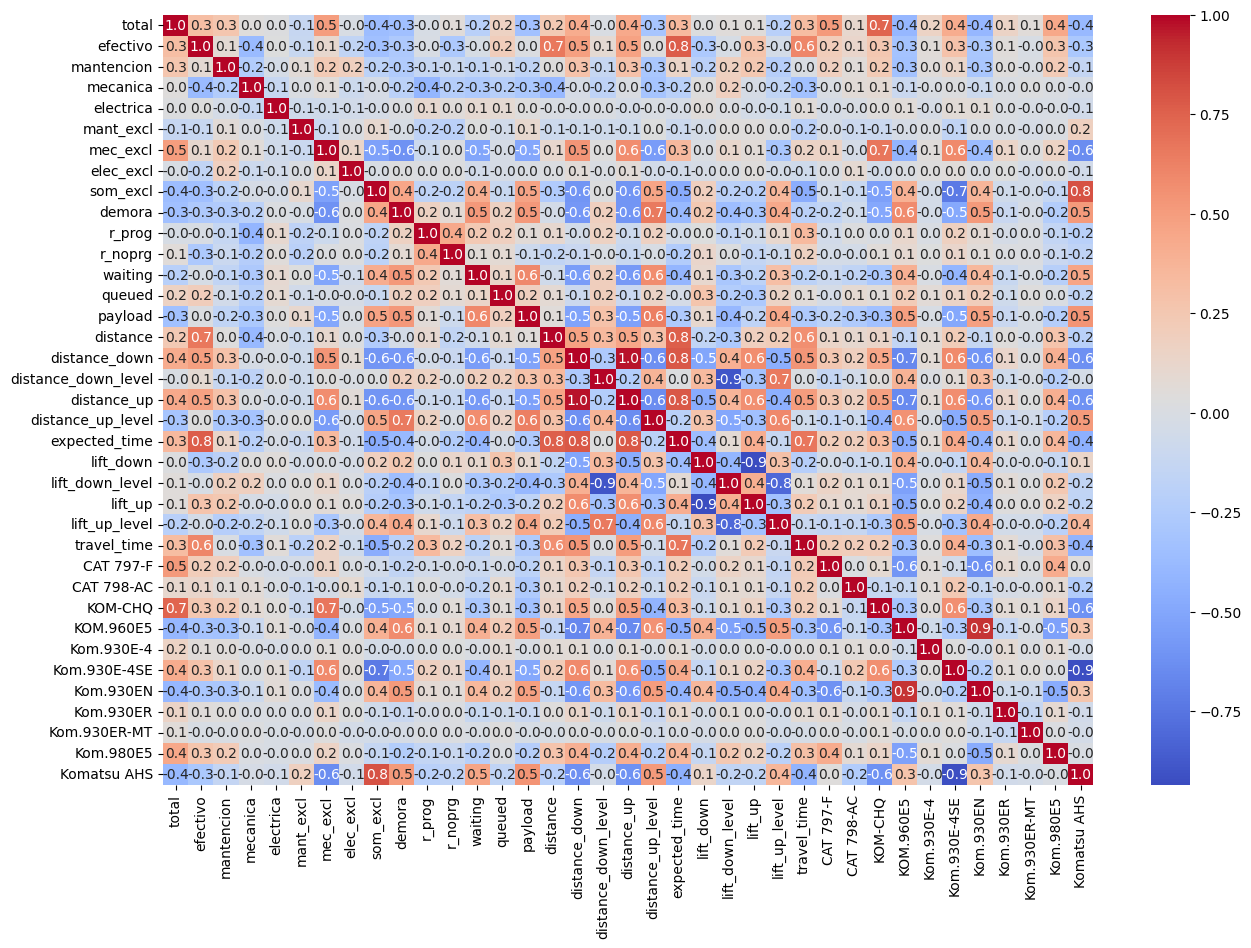

In [50]:
# generamos un heatmap para ver la correlación entre las variables numéricas
plt.figure(figsize=(15,10))
sns.heatmap(df_num.corr(method='spearman'), annot=True, cmap='coolwarm', fmt='.1f')

plt.show()

In [51]:
# ajustamos dataframe final
df_final = df_final.drop(var_corr, axis=1)

#### _3.4 Categorización de Variables_

In [52]:
# categorizamos la variable 'year' con one hot encoding
df_final = pd.get_dummies(df_final, columns=['year'], drop_first=True, dtype='category')

In [53]:
# categorizamos la variable 'month' con one hot encoding
df_final = pd.get_dummies(df_final, columns=['month'], drop_first=True, dtype='category')

In [54]:
# categorizamos la variable 'day' con one hot encoding
df_final = pd.get_dummies(df_final, columns=['day'], drop_first=True, dtype='category')

In [55]:
# categorizamos la variable 'shift' con one hot encoding
df_final = pd.get_dummies(df_final, columns=['shift'], drop_first=True, dtype='category')

In [56]:
# categorizamos la variable 'crew' con one hot encoding
df_final = pd.get_dummies(df_final, columns=['crew'], drop_first=True, dtype='category')

In [57]:
# ordenamos las columnas del dataframe final para que las variables categóricas queden al principio
col_cat = df_final.select_dtypes(include=['category']).columns.tolist()
col_num = df_final.select_dtypes(include=['float64','int64']).columns.tolist()

df_final = df_final[col_cat+col_num]

In [58]:
df_final.columns

Index(['year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21',
       'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28',
       'day_29', 'day_30', 'day_31', 'shift_B', 'crew_E2', 'crew_E3',
       'crew_E4', 'total', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'elec_excl', 'som_excl', 'demora', 'r_prog',
       'r_noprg', 'waiting', 'queued', 'payload', 'distance', 'distance_down',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ',
       'KOM.960E5', 'Kom.930E-4'

In [59]:
len(df_final.columns)   

84

## **_4. Gráficos de Interés_**

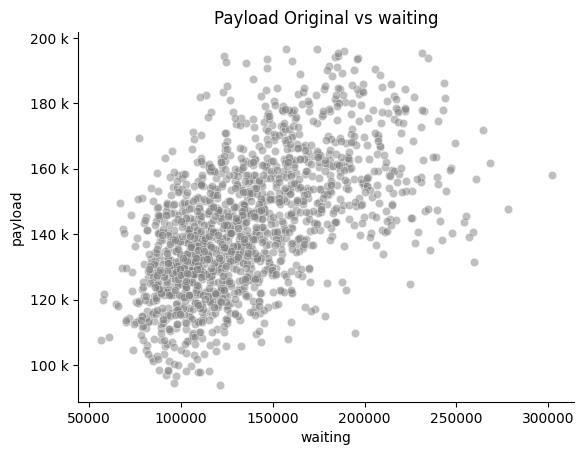

In [60]:
# graficamos 'payload_original' vs 'waiting'
sns.scatterplot(x='waiting', y='payload', data=df_grouped_final, alpha=0.5, color='gray')

sns.despine()
plt.title('Payload Original vs waiting') 
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.show()

In [62]:
# creamos nuevo dataframe para graficar los crew
df_melted = df_final[['crew_E2', 'crew_E3','crew_E4', 'payload']]
df_melted['crew_E1'] = [1 if (a+b+c) == 0 else 0 for a, b, c in zip(df_final['crew_E2'], df_final['crew_E3'], df_final['crew_E4'])]

# Función para determinar qué columna tiene un valor de 1 y retornar el nombre de esa columna
def get_column_name(row):
    for col in ['crew_E1', 'crew_E2', 'crew_E3', 'crew_E4']:
        if row[col] == 1:
            return col
    return None

# Aplicar la función a cada fila del DataFrame
df_melted['crew_name'] = df_melted.apply(get_column_name, axis=1)

/var/folders/m_/q3n8nryd24xfcpjsmy_8pw8c0000gn/T/ipykernel_2004/3923314173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_melted['crew_E1'] = [1 if (a+b+c) == 0 else 0 for a, b, c in zip(df_final['crew_E2'], df_final['crew_E3'], df_final['crew_E4'])]
/var/folders/m_/q3n8nryd24xfcpjsmy_8pw8c0000gn/T/ipykernel_2004/3923314173.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_melted['crew_name'] = df_melted.apply(get_column_name, axis=1)


In [63]:
df_melted

crew_E2 crew_E3 crew_E4        payload  crew_E1 crew_name
0      False   False    True  196048.794091        0   crew_E4
1       True   False   False  190410.046991        0   crew_E2
2      False   False    True  182896.714123        0   crew_E4
3       True   False   False  177821.821993        0   crew_E2
4      False   False    True  184522.752091        0   crew_E4
...      ...     ...     ...            ...      ...       ...
1562    True   False   False  120091.925007        0   crew_E2
1563   False    True   False  115654.846977        0   crew_E3
1564   False   False   False  110101.874020        1   crew_E1
1565   False    True   False  129817.423976        0   crew_E3
1566   False   False   False  128821.929870        1   crew_E1

[1567 rows x 6 columns]

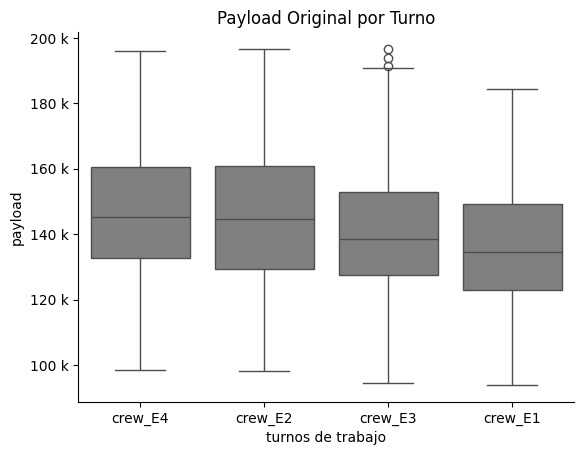

In [64]:
# graficamos 'payload_original' vs 'crew_name'
sns.boxplot(x='crew_name', y='payload', data=df_melted, color='gray')

sns.despine()
plt.title('Payload Original por Turno')
plt.xlabel('turnos de trabajo')
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.show()

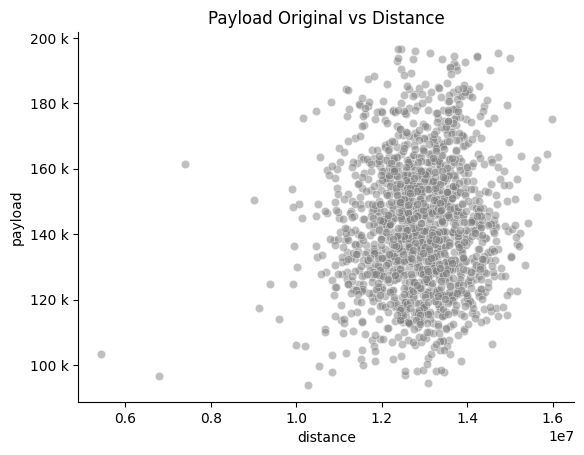

In [65]:
# graficamos 'payload_original' vs 'distance'
sns.scatterplot(x='distance', y='payload', data=df_grouped_final, alpha=0.5, color='gray')

sns.despine()
plt.title('Payload Original vs Distance') 
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.show()

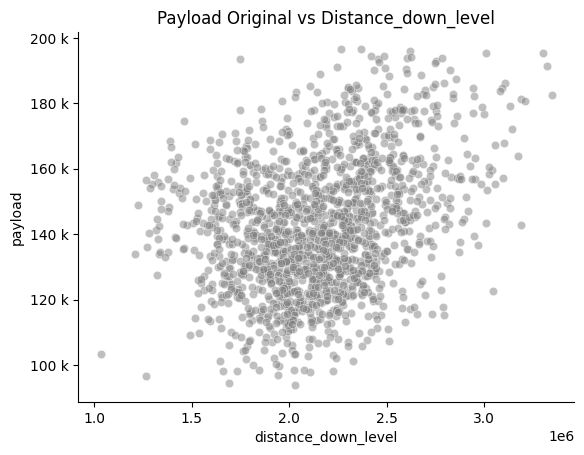

In [66]:
# graficamos 'payload_original' vs 'distance_down_level'
sns.scatterplot(x='distance_down_level', y='payload', data=df_grouped_final, alpha=0.5, color='gray')

sns.despine()
plt.title('Payload Original vs Distance_down_level') 
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.show()

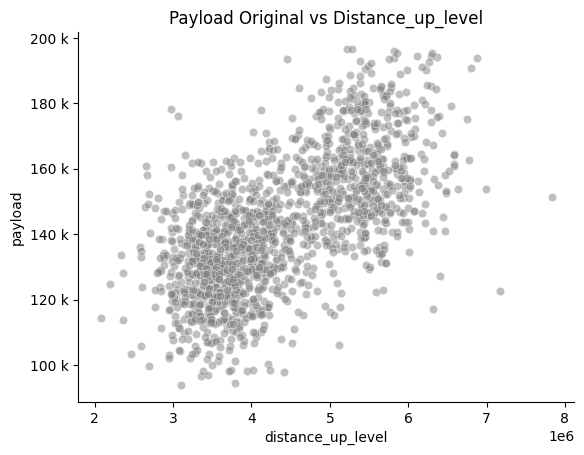

In [67]:
# graficamos 'payload_original' vs 'distance_up_level'
sns.scatterplot(x='distance_up_level', y='payload', data=df_grouped_final, alpha=0.5, color='gray')

sns.despine()
plt.title('Payload Original vs Distance_up_level') 
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.show()

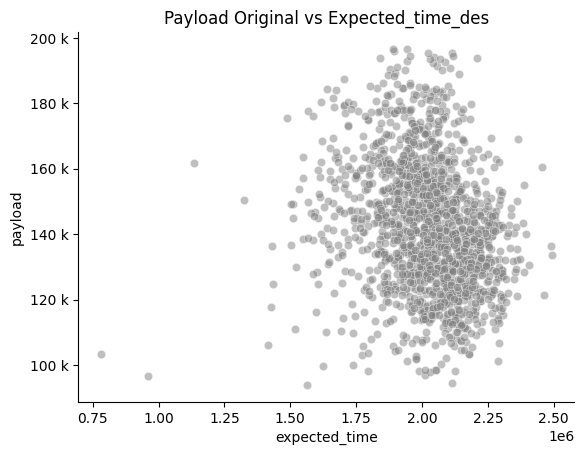

In [68]:
# graficamos 'payload_original' vs 'expected_time_des'
sns.scatterplot(x='expected_time', y='payload', data=df_final, alpha=0.5, color='gray')

sns.despine()
plt.title('Payload Original vs Expected_time_des') 
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.show()

In [69]:
df_final

year_2023 year_2024 month_2 month_3 month_4 month_5 month_6 month_7  \
0        False     False   False   False   False   False   False   False   
1        False     False   False   False   False   False   False   False   
2        False     False   False   False   False   False   False   False   
3        False     False   False   False   False   False   False   False   
4        False     False   False   False   False   False   False   False   
...        ...       ...     ...     ...     ...     ...     ...     ...   
1562     False      True    True   False   False   False   False   False   
1563     False      True    True   False   False   False   False   False   
1564     False      True    True   False   False   False   False   False   
1565     False      True    True   False   False   False   False   False   
1566     False      True    True   False   False   False   False   False   

     month_8 month_9  ... CAT 798-AC KOM-CHQ KOM.960E5 Kom.930E-4  \
0      False   False  ...        0.0     0.0      24.0       96.0   
1      False   False  ...        0.0     0.0      24.0       96.0   
2      False   False  ...        0.0     0.0      24.0       96.0   
3      False   False  ...        0.0     0.0      24.0       95.0   
4      False   False  ...        0.0     0.0      24.0       96.0   
...      ...     ...  ...        ...     ...       ...        ...   
1562   False   False  ...       24.0     0.0       0.0       96.0   
1563   False   False  ...       24.0     0.0       0.0       96.0   
1564   False   False  ...       24.0     0.0       0.0       96.0   
1565   False   False  ...       24.0     0.0       0.0       96.0   
1566   False   False  ...       24.0     0.0       0.0       96.0   

     Kom.930E-4SE Kom.930EN Kom.930ER Kom.930ER-MT Kom.980E5 Komatsu AHS  
0           395.0      96.0     240.0          0.0     132.0        24.0  
1           396.0      96.0     240.0          0.0     132.0        24.0  
2           394.0      96.0     240.0          0.0     132.0        24.0  
3           396.0      96.0     240.0          0.0     132.0        24.0  
4           395.0      96.0     240.0          0.0     132.0        24.0  
...           ...       ...       ...          ...       ...         ...  
1562        408.0      48.0     240.0          0.0     144.0         0.0  
1563        407.0      36.0     228.0          0.0     144.0         0.0  
1564        408.0      36.0     228.0          0.0     144.0         0.0  
1565        408.0      36.0     228.0          0.0     144.0         0.0  
1566        408.0      36.0     228.0          0.0     144.0         0.0  

[1567 rows x 84 columns]

In [70]:
# exportamos el dataframe final
df_final.to_csv('../Data/df_final_pay_sin_mt.csv', index=False)